<a href="https://colab.research.google.com/github/springboardmentor54158a/AIDriven-Archaeological-Site-Mapping/blob/Shreyansh/Ai_Artifect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install torch torchvision opencv-python albumentations tqdm


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class ArchaeologyDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = image / 255.0
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)

        # Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Decoder
        self.up = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.dec = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))

        d = self.up(e2)
        x = torch.cat([d, e1], dim=1)

        return self.dec(x)


In [ ]:
model = UNet(num_classes=3).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def dice_score(pred, target):
    pred = torch.argmax(pred, dim=1)
    smooth = 1e-6
    intersection = (pred == target).sum().float()
    return (2. * intersection + smooth) / (pred.numel() + target.numel() + smooth)


In [ ]:
def dice_score(pred, target, num_classes=3):
    pred = torch.argmax(pred, dim=1)
    dice = 0.0
    smooth = 1e-6

    for cls in range(num_classes):
        pred_c = (pred == cls).float()
        target_c = (target == cls).float()

        intersection = (pred_c * target_c).sum()
        dice += (2. * intersection + smooth) / (
            pred_c.sum() + target_c.sum() + smooth
        )

    return dice / num_classes


In [ ]:
from torch.utils.data import DataLoader

train_img_dir = "data/train/images"
train_mask_dir = "data/train/masks"

val_img_dir = "data/val/images"
val_mask_dir = "data/val/masks"


In [ ]:
base_path = "/content/drive/MyDrive/Ai Artifect Detection/data"

train_img_dir  = base_path + "/train/images"
train_mask_dir = base_path + "/train/masks"

val_img_dir  = base_path + "/val/images"
val_mask_dir = base_path + "/val/masks"


In [ ]:
import os
print(os.listdir(train_img_dir)[:5])
print(os.listdir(train_mask_dir)[:5])


['22679050_15.png', '22678990_15.png', '22678930_15.png', '22679005_15.png', '22678960_15.png']
['22678990_15.png', '22679050_15.png', '22678960_15.png', '22678915_15.png', '22679005_15.png']


In [ ]:
train_dataset = ArchaeologyDataset(train_img_dir, train_mask_dir)
val_dataset   = ArchaeologyDataset(val_img_dir, val_mask_dir)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    val_dice = 0

    with torch.no_grad():
        for img, mask in loader:
            img = img.to(device)
            mask = mask.to(device)

            output = model(img)
            loss = criterion(output, mask)

            val_loss += loss.item()
            val_dice += dice_score(output.detach(), mask.detach()).item()

    return val_loss / len(loader), val_dice / len(loader)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)


Using device: cuda


In [ ]:
def dice_score(pred, target, num_classes=3):
    pred = torch.argmax(pred, dim=1)
    dice = 0.0
    smooth = 1e-6

    for cls in range(1, num_classes):  # skip background = 0
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice += (2. * intersection + smooth) / (union + smooth)

    return dice / (num_classes - 1)


In [ ]:
def iou_score(pred, target, num_classes=3):
    pred = torch.argmax(pred, dim=1)
    iou = 0.0
    smooth = 1e-6

    for cls in range(1, num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        iou += (intersection + smooth) / (union + smooth)

    return iou / (num_classes - 1)


In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    dice_total = 0.0
    iou_total = 0.0

    with torch.no_grad():
        for img, mask in loader:
            img = img.to(device)
            mask = mask.to(device)

            output = model(img)
            loss = criterion(output, mask)

            total_loss += loss.item()
            dice_total += dice_score(output.detach(), mask).item()
            iou_total += iou_score(output.detach(), mask).item()

    return (
        total_loss / len(loader),
        dice_total / len(loader),
        iou_total / len(loader)
    )


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        smooth = 1e-6
        loss = 0.0

        for cls in range(1, self.num_classes):
            p = pred[:, cls]
            t = (target == cls).float()

            intersection = (p * t).sum()
            union = p.sum() + t.sum()

            loss += 1 - (2 * intersection + smooth) / (union + smooth)

        return loss / (self.num_classes - 1)


In [ ]:
import torch.nn as nn

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(num_classes=3)


In [ ]:
for img, mask in train_loader:
    img = img.to(device)
    mask = mask.to(device)

    output = model(img)

    loss = 0.5 * ce_loss(output, mask) + 0.5 * dice_loss(output, mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
class ArchaeologyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.images[idx]

        image = cv2.imread(os.path.join(self.image_dir, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, img_name), 0)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        image = cv2.resize(image, (256, 256)) / 255.0
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        image = torch.tensor(image).permute(2, 0, 1).float()
        mask = torch.tensor(mask).long()

        return image, mask


In [ ]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
])


In [ ]:
train_dataset = ArchaeologyDataset(
    train_img_dir,
    train_mask_dir,
    transform=transform
)

val_dataset = ArchaeologyDataset(
    val_img_dir,
    val_mask_dir,
    transform=None
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
def iou_score(pred, target, num_classes=3):
    pred = torch.argmax(pred, dim=1)
    iou = 0.0
    smooth = 1e-6

    for cls in range(1, num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        iou += (intersection + smooth) / (union + smooth)

    return iou / (num_classes - 1)


In [ ]:
num_epochs = 10
best_dice = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)

        loss = 0.5 * ce_loss(output, mask) + 0.5 * dice_loss(output, mask)

        optimizer.zero_grad()
        loss.backward()

        # 👉 YE LINE ADD KAR
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    val_loss, val_dice, val_iou = validate(
        model, val_loader, ce_loss, device
    )

    # 👉 YE BLOCK ADD KAR (MODEL SAVE)
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_unet_archaeology.pth")

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Dice: {val_dice:.4f} | "
        f"IoU: {val_iou:.4f}"
    )


Epoch [1/10] | Train Loss: 0.4544 | Val Loss: 0.1775 | Dice: 0.6397 | IoU: 0.5812
Epoch [2/10] | Train Loss: 0.4234 | Val Loss: 0.1684 | Dice: 0.6638 | IoU: 0.5980


In [ ]:
torch.save(model.state_dict(), "unet_archaeology_segmentation.pth")


In [ ]:

!pip install ultralytics albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.4 MB/s eta 0:00:00


In [ ]:
import ultralytics
import albumentations as A

print("Ultralytics version:", ultralytics.__version__)
print("Albumentations version:", A.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics version: 8.3.248
Albumentations version: 2.0.8


In [ ]:
!yolo detect train \
  model=yolov8n.pt \
  data="/content/drive/MyDrive/Ai Artifect Detection/yolo_data/data.yaml" \
  epochs=50 \
  imgsz=640


Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Ai Artifect Detection/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

In [ ]:
!yolo detect predict \
  model="runs/detect/train/weights/best.pt" \
  source="/content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images" \
  imgsz=640


Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/22978945_15_png.rf.cbcc49afffe56d2cca742e6cb4c05048.jpg: 640x640 (no detections), 9.5ms
image 2/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23429155_15_png.rf.a5991b41889f3689216cf33c7e049a3c (1).jpg: 640x640 (no detections), 12.8ms
image 3/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23429155_15_png.rf.a5991b41889f3689216cf33c7e049a3c.jpg: 640x640 (no detections), 10.3ms
image 4/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23579050_15_png.rf.8a64f51f2fedae26e8c49de609db1c33.jpg: 640x640 (no detections), 7.7ms
image 5/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23728930_15_png.rf.7a088e87df8aa78925bed433da71b030.jpg: 640x640 (no detections), 9.4ms


In [ ]:
!yolo detect predict \
  model="runs/detect/train/weights/best.pt" \
  source="/content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images" \
  imgsz=640 \
  conf=0.05


Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/22978945_15_png.rf.cbcc49afffe56d2cca742e6cb4c05048.jpg: 640x640 (no detections), 7.6ms
image 2/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23429155_15_png.rf.a5991b41889f3689216cf33c7e049a3c (1).jpg: 640x640 (no detections), 7.2ms
image 3/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23429155_15_png.rf.a5991b41889f3689216cf33c7e049a3c.jpg: 640x640 (no detections), 7.2ms
image 4/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23579050_15_png.rf.8a64f51f2fedae26e8c49de609db1c33.jpg: 640x640 1 structure_piece, 7.2ms
image 5/5 /content/drive/MyDrive/Ai Artifect Detection/yolo_data/valid/images/23728930_15_png.rf.7a088e87df8aa78925bed433da71b030.jpg: 640x640 1 structure_piece, 7.3m

In [ ]:
!yolo detect train \
  model=yolov8n.pt \
  data="/content/drive/MyDrive/Ai Artifect Detection/yolo_data/data.yaml" \
  epochs=150 \
  imgsz=640


Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Ai Artifect Detection/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
file_path = "/content/drive/MyDrive/Ai Artifect Detection/erosion_features_week5.csv"


In [ ]:
import pandas as pd

df = pd.read_csv(file_path)
df.head()


,vegetation_ratio,slope_score,erosion_label
0,0.353497,0.536340,1
1,0.333695,0.515612,1
2,0.577581,0.328621,0
3,0.284512,0.494239,1
4,0.285323,0.481242,1


In [ ]:
X = df[['vegetation_ratio', 'slope_score']]
y = df['erosion_label']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)
print("✅ Model trained successfully")


✅ Model trained successfully


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 0.0
R² Score: 1.0


In [ ]:
for feature, score in zip(X.columns, rf.feature_importances_):
    print(f"{feature} -> {score}")


vegetation_ratio -> 0.48484848484848486
slope_score -> 0.5151515151515151


In [ ]:
df['erosion_prediction'] = rf.predict(X)

save_path = "/content/drive/MyDrive/Ai Artifect Detection/erosion_predictions.csv"
df.to_csv(save_path, index=False)

print("📁 Saved at:", save_path)


📁 Saved at: /content/drive/MyDrive/Ai Artifect Detection/erosion_predictions.csv


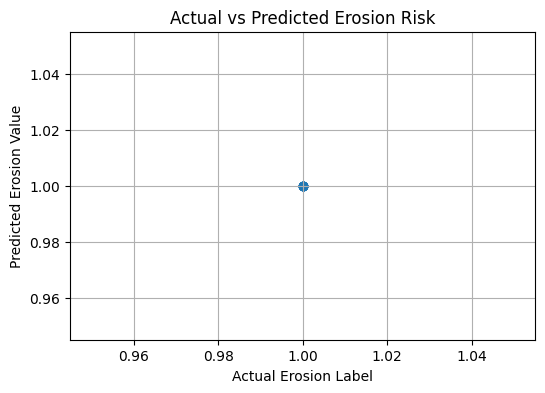

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Erosion Label")
plt.ylabel("Predicted Erosion Value")
plt.title("Actual vs Predicted Erosion Risk")
plt.grid(True)
plt.show()
